Below is a simple example of a job shop problem, in which each task is labeled by a pair of numbers (m, p) where m is the number of the machine the task must be processed on and p is the processing time of the task — the amount of time it requires. (The numbering of jobs and machines starts at 0.)

job 0 = [(0, 3), (1, 2), (2, 2)]

job 1 = [(0, 2), (2, 1), (1, 4)]

job 2 = [(1, 4), (2, 3)]

In the example, job 0 has three tasks. The first, (0, 3), must be processed on machine 0 in 3 units of time. The second, (1, 2), must be processed on machine 1 in 2 units of time, and so on. Altogether, there are eight tasks.


https://developers.google.com/optimization/scheduling/job_shop

In [37]:
import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import docplex.cp.utils_visu as visu


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

In [38]:
job_0 = [(0, 3), (1, 2), (2, 2)]
job_1 = [(0, 2), (2, 1), (1, 4)]
job_2 = [(1, 4), (2, 3)]

jobs_data = pd.DataFrame([])
i=0
for j in [job_0,  job_1,  job_2  ]: 
    u = pd.DataFrame(j, columns = ['machine','time'])
    u['job'] = i
    u['order'] = np.arange(0,len(u))
    jobs_data = pd.concat([jobs_data,u], axis = 0)
    i=i+1

jobs_data = jobs_data[['job','order', 'machine', 'time']].reset_index(drop = True)
jobs_data

,job,order,machine,time
0,0,0,0,3
1,0,1,1,2
2,0,2,2,2
3,1,0,0,2
4,1,1,2,1
5,1,2,1,4
6,2,0,1,4
7,2,1,2,3


In [39]:
horizon = jobs_data['time'].sum()
horizon

21

In [40]:
mdl = CpoModel(name="JobScheduling")


DV=[]
for row in jobs_data.itertuples():
    #print(i)
    dv = mdl.interval_var(size  =  row.time, name='Machine%s_Job%s'%(row.machine, row.job ))# ,  , 
    DV.append(dv) 
jobs_data['DV'] = DV
jobs_data

,job,order,machine,time,DV
0,0,0,0,3,Machine0_Job0 = intervalVar(size=3)
1,0,1,1,2,Machine1_Job0 = intervalVar(size=2)
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2)
3,1,0,0,2,Machine0_Job1 = intervalVar(size=2)
4,1,1,2,1,Machine2_Job1 = intervalVar(size=1)
5,1,2,1,4,Machine1_Job1 = intervalVar(size=4)
6,2,0,1,4,Machine1_Job2 = intervalVar(size=4)
7,2,1,2,3,Machine2_Job2 = intervalVar(size=3)


mdl.add( mdl.end_before_start(DV[0], DV[1]) )
mdl.add( mdl.end_before_start(DV[0], DV[2]) )
mdl.add( mdl.end_before_start(DV[1], DV[2]) )


print("\nSolving model....")
msol = mdl.solve(TimeLimit=10)
print("done")

In [41]:
all_jobs = jobs_data['job'].unique()
all_machines = jobs_data['machine'].unique()


def extract_precedence(m):
    AllOrders = []
    for i in m.keys():
        for j in m.keys():
            if m[i]<m[j]:
                AllOrders.append([i,j])

    return AllOrders


for i in all_jobs:
    u= jobs_data[jobs_data['job']==i]
    m = dict(zip(u.index, u.order.values))
    precedence_list = extract_precedence(m)

    for j in precedence_list:
        print("The task ", jobs_data.loc[j[0]]['DV'] , '   should be before   ', jobs_data.loc[j[1]]['DV'])

        mdl.add( mdl.end_before_start(jobs_data.loc[j[0]]['DV'], jobs_data.loc[j[1]]['DV']) )



The task  Machine0_Job0 = intervalVar(size=3)    should be before    Machine1_Job0 = intervalVar(size=2)
The task  Machine0_Job0 = intervalVar(size=3)    should be before    Machine2_Job0 = intervalVar(size=2)
The task  Machine1_Job0 = intervalVar(size=2)    should be before    Machine2_Job0 = intervalVar(size=2)
The task  Machine0_Job1 = intervalVar(size=2)    should be before    Machine2_Job1 = intervalVar(size=1)
The task  Machine0_Job1 = intervalVar(size=2)    should be before    Machine1_Job1 = intervalVar(size=4)
The task  Machine2_Job1 = intervalVar(size=1)    should be before    Machine1_Job1 = intervalVar(size=4)
The task  Machine1_Job2 = intervalVar(size=4)    should be before    Machine2_Job2 = intervalVar(size=3)


In [42]:
for i in all_machines:
    u= jobs_data[jobs_data['machine']==i]
    print(   u['DV'].values.tolist(), "  shouldn't overlap")
    mdl.add ( mdl.no_overlap(  u['DV'].values.tolist()))
u

[<docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F10740>, <docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F105F0>]   shouldn't overlap
[<docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F10900>, <docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F104A0>, <docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F10430>]   shouldn't overlap
[<docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F10040>, <docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F100B0>, <docplex.cp.expression.CpoIntervalVar object at 0x000002A3B7F10580>]   shouldn't overlap


,job,order,machine,time,DV
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2)
4,1,1,2,1,Machine2_Job1 = intervalVar(size=1)
7,2,1,2,3,Machine2_Job2 = intervalVar(size=3)


In [43]:
for i in all_machines:
    u= jobs_data[jobs_data['order']==2]
    u.loc[:,'endtime']=u['DV'].apply(lambda x:mdl.end_of(x))
u

C:\Users\m_gor\AppData\Local\Temp\ipykernel_2880\2871035407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.loc[:,'endtime']=u['DV'].apply(lambda x:mdl.end_of(x))
C:\Users\m_gor\AppData\Local\Temp\ipykernel_2880\2871035407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.loc[:,'endtime']=u['DV'].apply(lambda x:mdl.end_of(x))
C:\Users\m_gor\AppData\Local\Temp\ipykernel_2880\2871035407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,job,order,machine,time,DV,endtime
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2),endOf(Machine2_Job0)
5,1,2,1,4,Machine1_Job1 = intervalVar(size=4),endOf(Machine1_Job1)


In [44]:
jobs_data

,job,order,machine,time,DV
0,0,0,0,3,Machine0_Job0 = intervalVar(size=3)
1,0,1,1,2,Machine1_Job0 = intervalVar(size=2)
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2)
3,1,0,0,2,Machine0_Job1 = intervalVar(size=2)
4,1,1,2,1,Machine2_Job1 = intervalVar(size=1)
5,1,2,1,4,Machine1_Job1 = intervalVar(size=4)
6,2,0,1,4,Machine1_Job2 = intervalVar(size=4)
7,2,1,2,3,Machine2_Job2 = intervalVar(size=3)


In [45]:
# Find the latest task of each job
idx=  jobs_data.groupby(by='job')['order'].idxmax()
last_Tasks = jobs_data.loc[idx,]

last_Tasks['endtime'] = last_Tasks['DV'].apply(lambda x:mdl.end_of(x) )
last_Tasks


,job,order,machine,time,DV,endtime
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2),endOf(Machine2_Job0)
5,1,2,1,4,Machine1_Job1 = intervalVar(size=4),endOf(Machine1_Job1)
7,2,1,2,3,Machine2_Job2 = intervalVar(size=3),endOf(Machine2_Job2)


In [46]:
obj = mdl.minimize ( mdl.max ( last_Tasks['endtime']) )
mdl.add(obj)

msol = mdl.solve(TimeLimit=10)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 11 variables, 10 constraints
 ! TimeLimit            = 10
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 24.0 (before), 24.0 (after)
 !  . Memory usage      : 440.8 kB (before), 440.8 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         11                 -
 + New bound is 7
 *            11       17  0.02s        1      (gap is 36.36%)
              11       18          4    1   F        -
 + New bound is 11 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 11 (optimal - effective tol. is 0)
 ! Best bound             : 11
 ! -----------------------

In [47]:
jobs_data['DV_sol']=jobs_data['DV'].apply(lambda x:msol.get_var_solution(x))
jobs_data['DV_sol_start']=jobs_data['DV_sol'].apply(lambda x:x.get_start())
jobs_data['DV_sol_end']=jobs_data['DV_sol'].apply(lambda x:x.get_end())


jobs_data.sort_values(['DV_sol_start','DV_sol_end'])

,job,order,machine,time,DV,DV_sol,DV_sol_start,DV_sol_end
0,0,0,0,3,Machine0_Job0 = intervalVar(size=3),"Machine0_Job0: (start=0, end=3, size=3, length=3)",0,3
6,2,0,1,4,Machine1_Job2 = intervalVar(size=4),"Machine1_Job2: (start=0, end=4, size=4, length=4)",0,4
3,1,0,0,2,Machine0_Job1 = intervalVar(size=2),"Machine0_Job1: (start=3, end=5, size=2, length=2)",3,5
1,0,1,1,2,Machine1_Job0 = intervalVar(size=2),"Machine1_Job0: (start=4, end=6, size=2, length=2)",4,6
4,1,1,2,1,Machine2_Job1 = intervalVar(size=1),"Machine2_Job1: (start=5, end=6, size=1, length=1)",5,6
7,2,1,2,3,Machine2_Job2 = intervalVar(size=3),"Machine2_Job2: (start=6, end=9, size=3, length=3)",6,9
5,1,2,1,4,Machine1_Job1 = intervalVar(size=4),"Machine1_Job1: (start=6, end=10, size=4, length=4)",6,10
2,0,2,2,2,Machine2_Job0 = intervalVar(size=2),"Machine2_Job0: (start=9, end=11, size=2, length=2)",9,11


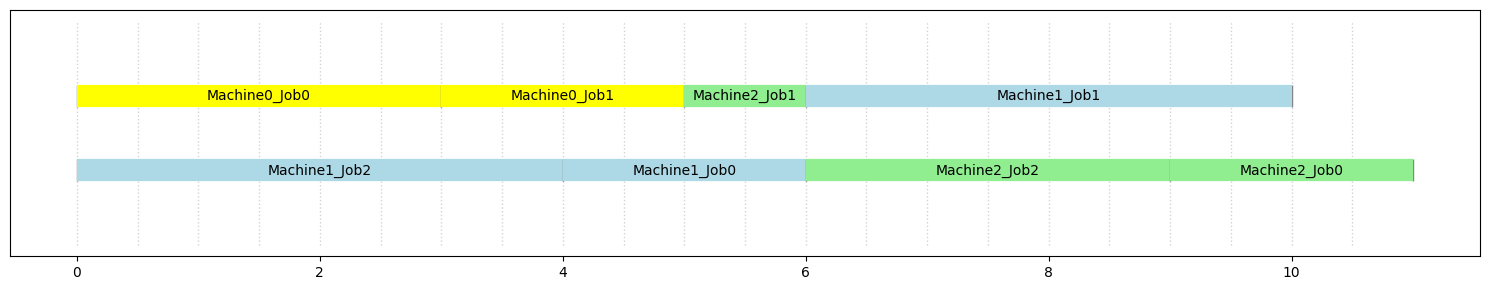

In [48]:
colors = ['yellow', 'lightblue', 'lightgreen']

for i in DV:
    var_sol = msol.get_var_solution(i)
    machine_id = int(i.name.split('_')[0].replace("Machine",''))
    #visu.panel()
    visu.interval(var_sol, colors[machine_id], i.name, )  
visu.show()